# SpotiOrganizer

Este proyecto busca resolver el problema que representa el tener muchas canciones en likes, agrupándolas en playlists utilizando algoritmos de clustering como K-means. 

Para ello, se analiza el genero de la cancion y otros metadatos asociados a las caracteristicas del audio.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Obtencion de la lista de "Me Gustas" del usuario

### Conectarse con Spotipy

Para acceder a esta informacion se requiere generar unas credenciales en "Spotify Developer Dashboard", se debe configurar el `.env` para poder autenticarse correctamente (El URL de redireccion no necesariamente debe ser valido, pero si identico).

In [4]:
from dotenv import load_dotenv
import os
import spotipy
from spotipy.oauth2 import SpotifyOAuth


load_dotenv(".env")

scope = 'user-library-read,playlist-modify-public,playlist-modify-private'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=os.getenv('SPOTIPY_CLIENT_ID'),
    client_secret=os.getenv('SPOTIPY_CLIENT_SECRET'),
    redirect_uri=os.getenv('SPOTIPY_REDIRECT_URI'),
    scope=scope
))


### Obtener la lista de origen
En este caso estamos obteniendo la lista de "Me gustas" del usuario, para poder analizarla.

In [5]:
try:
    results = sp.current_user_saved_tracks()
except Exception as e:
    print(f'Error al obtener las canciones del usuario: {e}')

tracks = results['items']

while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])

print(f'Total de canciones: {len(tracks)}')


Total de canciones: 571


### Enriquecimiento de Datos

Crearemos un dataframe que contendrá la información de la canción, incluyendo el ID, nombre, y artista.

Dado que el género no siempre está disponible, imputaremos el género basado en el primer artista de la canción.

Además, extraeremos las características del audio para un análisis más profundo.



In [6]:
from tqdm import tqdm
import time

track_data = []

audio_feature_numerical_keys = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence',
]
audio_feature_categorical_keys = ['tempo', 'time_signature', 'key', 'mode']

artist_genre_cache = {} # hash map para disminuir las llamadas a la API

def get_artist_genre(artist_id):
    if artist_id in artist_genre_cache:
        return artist_genre_cache[artist_id]
    
    artist_info = sp.artist(artist_id)
    genres = artist_info.get('genres', [])
    artist_genre_cache[artist_id] = genres
    return genres


for item in tqdm(tracks,  desc="Procesando pistas", unit="pista"):
    try:
        track = item['track']
        artist_id = track['artists'][0]['id']
        track_id = track['id']
        
        genres = get_artist_genre(artist_id)
        genre = genres[0] if genres else None
        
        audio_features = sp.audio_features(track_id)[0]
        
        track_info = {
            'id': track_id,
            'name': track['name'],
            'artist': track['artists'][0]['name'],
            'genre': genre
        }
        
        for key in audio_feature_numerical_keys:
            track_info[key] = audio_features.get(key)

        for key in audio_feature_categorical_keys:
            track_info[key] = audio_features.get(key)
        
        track_data.append(track_info)
    except Exception as e:
        print(f"Error al procesar {track['name']}: {e}")

df = pd.DataFrame(track_data)
df.head()

Procesando pistas:   0%|          | 0/571 [00:00<?, ?pista/s]

Procesando pistas: 100%|██████████| 571/571 [03:32<00:00,  2.69pista/s]


,id,name,artist,genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,key,mode
0,3D4iziSjHi4jxG8r4pta7z,Santiago De Chile,Los Bunkers,chilean rock,0.558,0.801,-5.796,0.0489,0.000126,0.000050,0.1760,0.542,120.090,4,2,0
1,19CmuECYssqkPWANF4nLWM,Para No Verte Más,La Mosca Tse-Tse,latin alternative,0.658,0.815,-6.834,0.1050,0.016800,0.000000,0.3410,0.837,99.276,4,0,1
2,2LsbizbOeNa4x6qsi2jAMb,La flaca,Jarabe De Palo,latin alternative,0.871,0.481,-9.068,0.0383,0.520000,0.000055,0.0809,0.664,103.063,4,7,1
3,6hBfF54vgIAdtb5kbbvt75,Nada Nuevo Bajo El Sol,Los Bunkers,chilean rock,0.483,0.891,-4.813,0.0304,0.069300,0.001220,0.0826,0.820,136.703,4,6,0
4,1qgtSWA2GbpAXfyC51M1ph,Por Ti,4x3,latin viral rap,0.761,0.535,-7.665,0.0600,0.882000,0.000000,0.1830,0.899,90.965,4,8,1


## Analisis Exploratorio (EDA):

#### Resumen estadistico
Observamos que los datos numericos se encuentran normalizados [0-1] a excepcion del volumen

In [7]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,key,mode
count,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000
mean,0.614336,0.723367,-6.652056,0.103882,0.221417,0.073948,0.192347,0.603167,120.920900,3.915937,5.316988,0.513135
std,0.151183,0.197671,3.615472,0.103663,0.267174,0.226306,0.150128,0.229578,31.263901,0.392842,3.573201,0.500266
min,0.000000,0.014600,-31.047000,0.000000,0.000018,0.000000,0.032400,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.516000,0.618000,-7.750500,0.039750,0.016950,0.000000,0.096200,0.440000,95.031500,4.000000,2.000000,0.000000
50%,0.621000,0.766000,-5.782000,0.061200,0.098100,0.000001,0.135000,0.618000,115.063000,4.000000,6.000000,1.000000
75%,0.723000,0.870500,-4.397000,0.116000,0.359000,0.000420,0.249000,0.794500,144.082500,4.000000,9.000000,1.000000
max,0.940000,0.991000,1.099000,0.841000,0.994000,0.973000,0.984000,0.978000,207.771000,5.000000,11.000000,1.000000


Algunos generos no pudieron ser recuperados. Si la tasa de error es menor al 10% imputaremos la esta var cualitativa nominal con la moda.

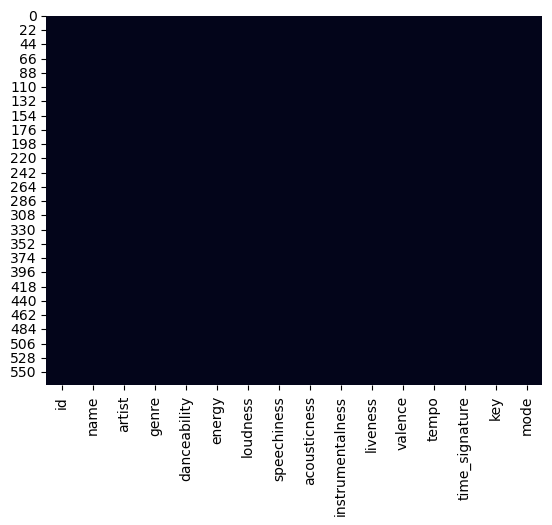

Filas con valores nulos: 0
No se imputo el genero porque el porcentaje de nulos es 0.00%
Filas duplicadas eliminadas: 0


In [17]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()
print(f'Filas con valores nulos: {df.isnull().sum().sum()}')

percent_null_genre = df['genre'].isnull().sum() / len(df)

if percent_null_genre < 0.1 and percent_null_genre > 0:
    moda = df["genre"].mode()[0]
    df['genre'] = df['genre'].fillna(moda)
    print(f'Se imputo {percent_null_genre:.2%} del genero con la moda {moda}') 
    print(f'Filas con valores nulos: {df.isnull().sum().sum()}')
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()
else:
    print(f'No se imputo el genero porque el porcentaje de nulos es {percent_null_genre:.2%}')

n = len(df)
df = df.drop_duplicates()
print(f'Filas duplicadas eliminadas: {n - len(df)}')




#### Distribución de las variables

La interpretacion de las variables del analisis del audio de las canciones se realiza de acuerdo a [Anero, 2020](https://www.linkedin.com/pulse/tendencias-hist%C3%B3ricas-del-%C3%A9xito-musical-trav%C3%A9s-de-los-gonzalo/):

Para este usuario en particular, observamos 

##### 1. Danceability
- **Distribución**: Ligeramente sesgada hacia la izquierda, con un pico entre 0.6 - 0.8.
- **Interpretación**: Las canciones de este usuario suelen ser bastante bailables, con tendencia a un "danceability" alto.

##### 2. Energy
- **Distribución**: Sesgada hacia la derecha, con un pico entre 0.7 - 0.9.
- **Interpretación**: Las canciones del usuario suelen ser bastante energéticas, con tendencia a un "energy" muy alto.

##### 3. Loudness
- **Distribución**: Pico muy definido entre -10db y 0db.
- **Interpretación**: Las canciones del usuario suelen tener un volumen bastante alto.

##### 4. Speechiness
- **Distribución**: Muy sesgada hacia la izquierda (0.0 - 0.2).
- **Interpretación**: En la mayoría de las canciones del usuario la letra no se recita, sino que se canta.

##### 5. Acousticness
- **Distribución**: Extremadamente sesgada hacia la izquierda.
- **Interpretación**: La mayoría de las canciones son producidas con poca influencia acústica, sugiriendo un énfasis en la producción digital.

##### 6. Instrumentalness
- **Distribución**: Muy sesgada a la izquierda, con valores cercanos a 0. 
- **Interpretación**: Esto indica que la mayoría de las canciones en el dataset tienen letras.

##### 7. Liveness
- **Distribución**: Sesgada hacia la izquierda, con una gran cantidad de valores bajos.
- **Interpretación**: La mayoría de las canciones no son grabaciones en vivo.

##### 8. Valence
- **Distribución**: Pico entre 0.6 - 0.8, con inclinación hacia la derecha.
- **Interpretación**: La mayoría de las canciones tienen una valencia alta, sonando felices o alegres, con variedad en canciones de tono más neutral.

#### Observaciones extra.
- Danceability incluye el tempo, la estabilidad rítmica, la intensidad del pulso y la regularidad general, serian candidatos a excluir de nuestro modelo de clustering.
- Ademas, seria conveniente incluir la duracion dado que varia por rango de años.

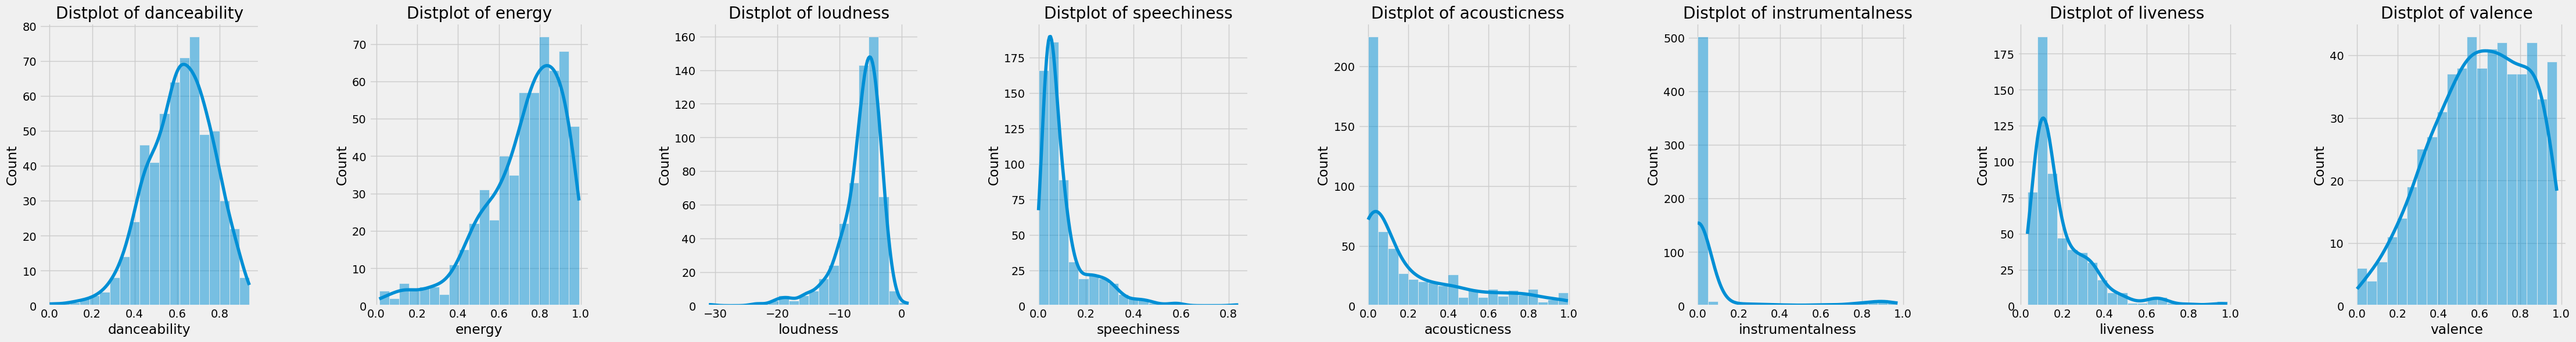

In [11]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (50 , 6))
n = 0 
for x in audio_feature_numerical_keys:
    n += 1
    plt.subplot(1 , len(audio_feature_numerical_keys) , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.histplot(df[x] , bins = 20, kde=True)
    plt.title('Distplot of {}'.format(x))
plt.show()

#### Analsis de Correlacion
Se busca identificar relaciones importantes entre las caractersticas para decidir como enfocar el modelo de clasificacion. Esto se hace par mantener simplicidad y minimizar el riesgo de sobreajuste (para que no aprenda ruido mi gallo)

1. La energia y el volumen de las canciones estan estrechamente ligadas. (directa)
2. Las canciones acusticas tienden a ser menos energeticas y menos rudidosas. (inversa)
3. La danzabilidad y la valencia estan ligeramente relacionadas, las canciones alegres deben ser mas bailables. (directa)

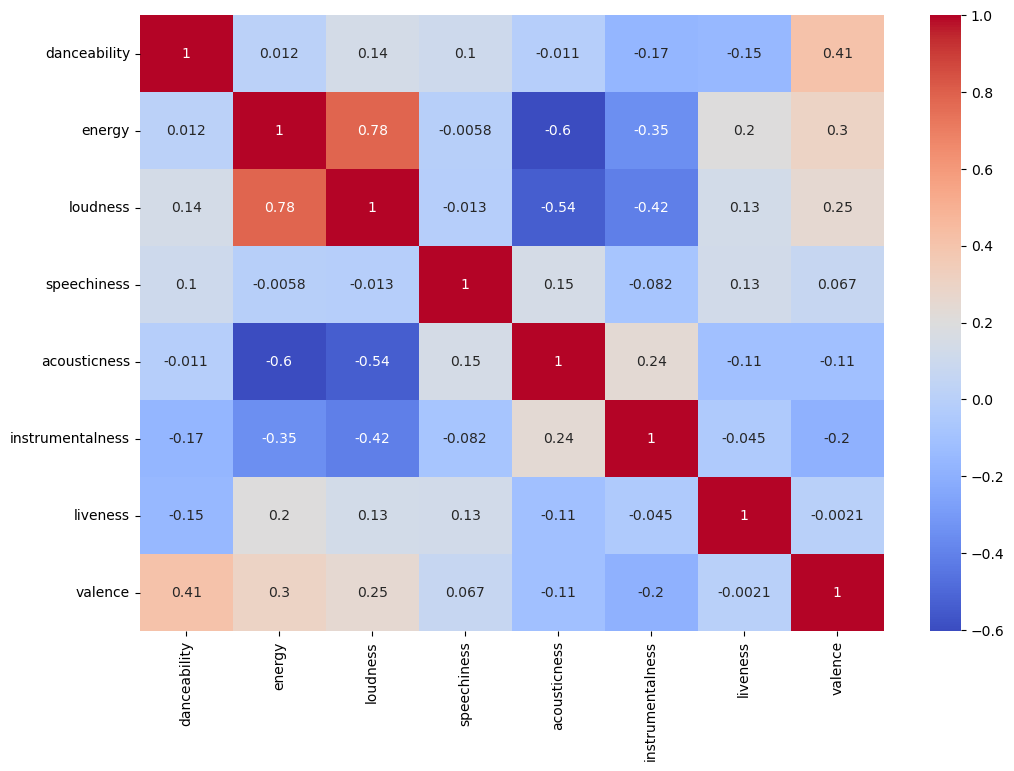

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[audio_feature_numerical_keys].corr(), annot=True, cmap='coolwarm')
plt.show()


## Clustering

### K-Means 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

La idea es usar TF-IDF (Term Frecuency - Inverse Document Frecuency) para representar los generos como vectores numericos

In [13]:
genres_list = [' '.join(genres) for genres in df['genre']]
track_genre_mapping = []

for i, genres in enumerate(df['genre']):
    for genre in genres:
        track_genre_mapping.append({
            'track': df['name'][i],
            'artist': df['artist'][i],
            'genre': genre
        })

track_genre_df = pd.DataFrame(track_genre_mapping)


Pero primero probaremos el rendimiento solo con los numericos

In [14]:
audio_features = df[audio_feature_numerical_keys].to_numpy() 


#### Normalizacion
para realizar el calculo de distancias correctamente.

In [15]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(genres_list) 

# Matriz numpy y normalización
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(audio_features)

#### Seleccion de nro de Clusterns
Se usara el metodo del codo, para emplear un criterio experto

c:\Users\rodyv\anaconda3\envs\spotify\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\rodyv\anaconda3\envs\spotify\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\rodyv\anaconda3\envs\spotify\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\rodyv\anaconda3\envs\spotify\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarn

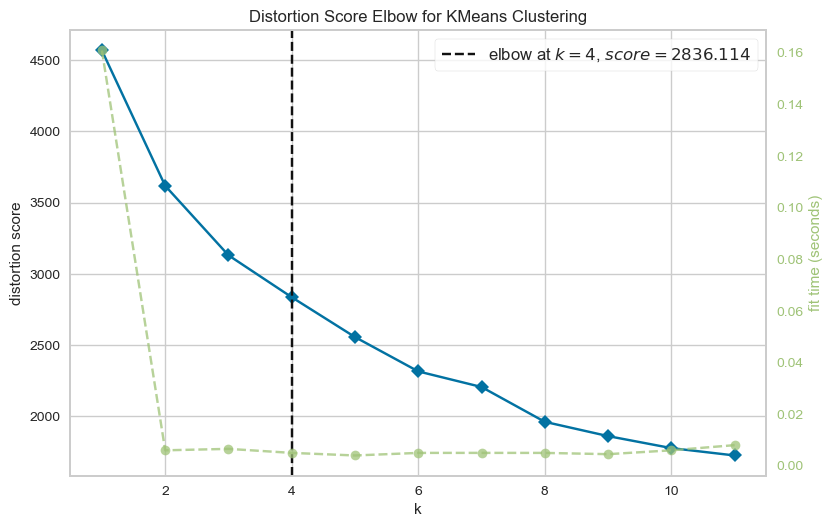

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X_scaled)      
visualizer.show()        

#### Entrenamiento del modelo

In [17]:
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters ,init='k-means++', n_init = 10 ,max_iter=10000, 
                 tol=0.0001, algorithm='lloyd', random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_   
centroides = kmeans.cluster_centers_   

df['cluster'] =  labels

c:\Users\rodyv\anaconda3\envs\spotify\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


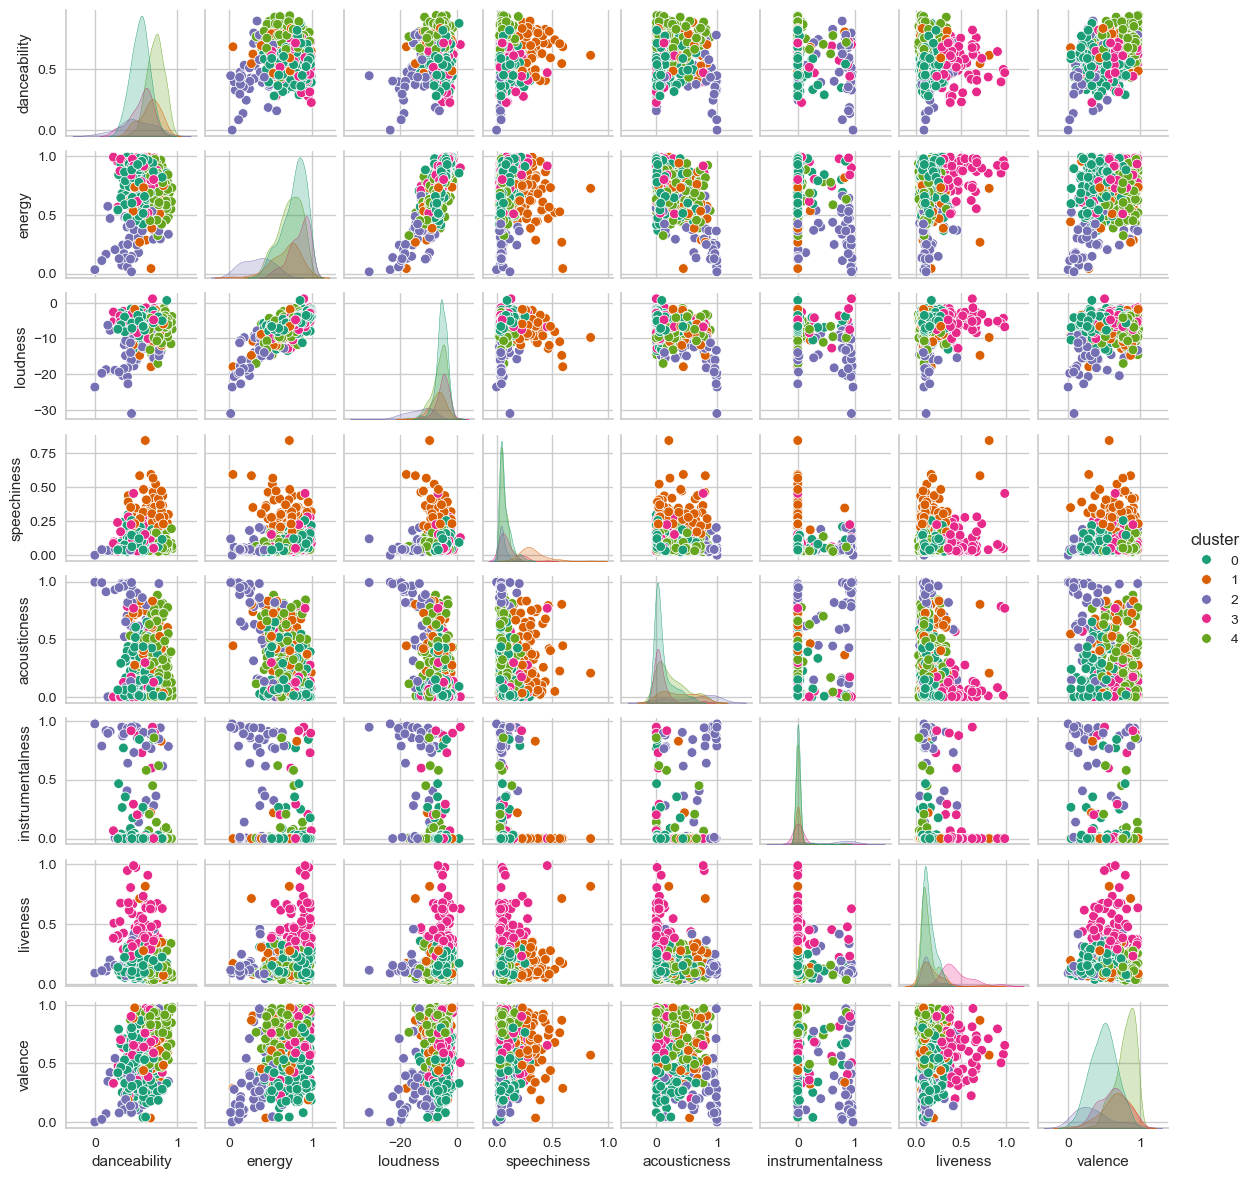

In [18]:
plot = sns.pairplot(df, hue='cluster', diag_kind='kde', palette='Dark2', height=1.5)
plt.show()


### Reduccion de dimensionalidad
Dado que usamos al menos 11 dimensiones para el clustering nos veremos obligados a reducir la dimensionalidad para poder observar los clusters sin dificultadad

In [22]:
from sklearn.decomposition import PCA
import plotly.express as px


# Ajustar el modelo PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)


df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = df['cluster']


fig = px.scatter_3d(df_pca, 
                    x='PC1', 
                    y='PC2', 
                    z='PC3', 
                    color='cluster', 
                    height=800, 
                    width=800)

# Guardar el gráfico como un archivo HTML
fig.write_html("file5k.html")

# Mostrar el gráfico
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Por si el grafico interactivo no se muestra en GH

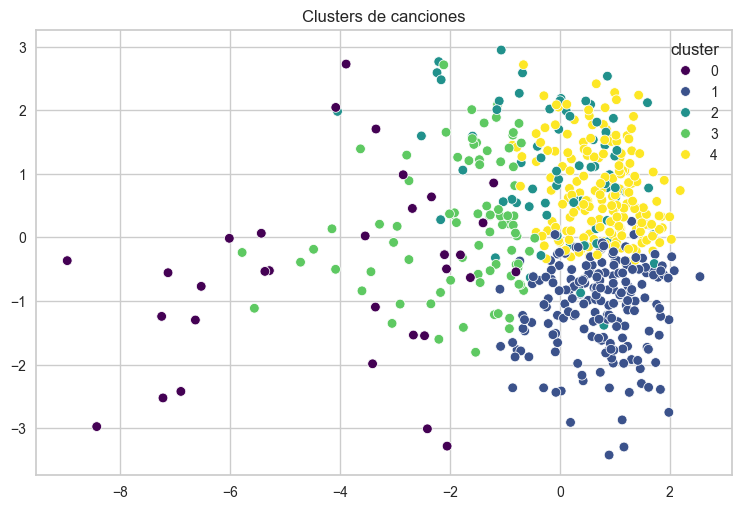

In [ ]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis')
plt.title('Clusters de canciones')
plt.show()


### Subir los clusters como playlist


In [ ]:
df['cluster'].value_counts()

cluster
1    193
4    189
3     84
2     74
0     33
Name: count, dtype: int64

In [156]:
def add_tracks_to_playlist(playlist_id, tracks):
    print(f"Añadiendo {len(tracks)} pistas a la playlist {playlist_id}")
    for i in tqdm(range(0, len(tracks), 100)):  # Dividir en lotes de 100
        batch = tracks[i:i + 100]
        try:
            results = sp.playlist_add_items(playlist_id, batch)
        except spotipy.exceptions.SpotifyException as e:
            print(f"Error al añadir pistas a la playlist {playlist_id}: {e}")
            # Esperar medio segundo antes de intentar de nuevo
            time.sleep(0.5)
            continue



for i in tqdm(range(n_clusters), desc="Creando listas de reproducción", unit="cluster"):
    cluster_tracks = df[df['cluster'] == i]
    if not cluster_tracks.empty:
        playlist_name = f"Cluster {i+1} Playlist"
        
        try:
            # Crear la playlist
            playlist = sp.user_playlist_create(user=sp.current_user()['id'], name=playlist_name)
        except spotipy.exceptions.SpotifyException as e:
            print(f"Error al crear la playlist {playlist_name}: {e}")
            continue
        
        track_ids = cluster_tracks['id'].tolist()  # Obtener los IDs de las pistas directamente del DataFrame
        
        if track_ids:
            try:
                add_tracks_to_playlist(playlist['id'], track_ids)
                print(f"Lista de reproducción creada: {playlist_name}")
            except spotipy.exceptions.SpotifyException as e:
                print(f"Error al añadir pistas a la playlist {playlist_name}: {e}")
        else:
            print(f"No se añadieron pistas a la playlist: {playlist_name}")

Creando listas de reproducción:   0%|          | 0/5 [00:00<?, ?cluster/s]

Añadiendo 33 pistas a la playlist 3QRy0mcWR6dxYH08oqwwqc


Creando listas de reproducción:  20%|██        | 1/5 [00:00<00:03,  1.20cluster/s]

Lista de reproducción creada: Cluster 1 Playlist
Añadiendo 193 pistas a la playlist 7cDv9BET0oWPgdgNfZR1SP


Creando listas de reproducción:  40%|████      | 2/5 [00:01<00:03,  1.02s/cluster]

Lista de reproducción creada: Cluster 2 Playlist
Añadiendo 74 pistas a la playlist 1bGTXKKBGpTvRLg4v8TGbN


Creando listas de reproducción:  60%|██████    | 3/5 [00:02<00:01,  1.07cluster/s]

Lista de reproducción creada: Cluster 3 Playlist
Añadiendo 84 pistas a la playlist 087Oi5zykPXDyySWw3Bfdp


Creando listas de reproducción:  80%|████████  | 4/5 [00:03<00:00,  1.10cluster/s]

Lista de reproducción creada: Cluster 4 Playlist
Añadiendo 189 pistas a la playlist 7pz9ACKYdIlYOopstbXYeT


Creando listas de reproducción: 100%|██████████| 5/5 [00:04<00:00,  1.03cluster/s]

Lista de reproducción creada: Cluster 5 Playlist
